## Imports

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from datetime import datetime
nlp = spacy.load("en_core_web_sm")

In [23]:
def string_to_date(str_date):
    if len(str(str_date)) == "":
        return None
    for fmt in ('%d %B %Y', '%d %b %Y', '%B %Y', "%b %Y", "%Y"):
        try:
            return datetime.strptime(str(str_date), fmt)
        except ValueError:
            pass
    raise ValueError(f'no valid date format found for {str_date}')

In [24]:
letters = pd.read_pickle("letters.pickle")
original_dates_corrected = pd.read_csv("original_dates.csv", sep=";")

letters = pd.merge(letters, original_dates_corrected, left_index=True, right_on="index").dropna()
letters.original_date_corrected = letters.original_date_corrected.apply(string_to_date)
letters.head(5)

,author,original_date,original_place,languages,letter_content,index,original_date_corrected
199,Isaac Newton,23 February 1668/9,England,"[English, Latin]",3 Trinity College Cambridge Feb: 23d 16689 Sir...,NATP00226,1668-02-23 00:00:00
200,Isaac Newton,18 May 1669,England,"[English, Latin]",4 Trinity College Cambridge May 18 1669 Franci...,NATP00227,1669-05-18 00:00:00
197,Isaac Newton,19 January 1669/70,England,[English],1 Trinity College Cambridge. Ian 1669 Sir I re...,NATP00224,1669-01-19 00:00:00
198,Isaac Newton,6 February 1669/70,England,"[English, French]",2 Trinity College Feb 6 1669.Cambridge. Sir Mr...,NATP00225,1669-02-06 00:00:00
201,Isaac Newton,18 February 1669/70,England,[English],5. Feb 18th 166970. Sir Two days since I recei...,NATP00228,1669-02-18 00:00:00


## Data exploration

### Counting 

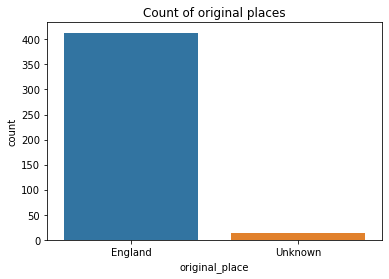

In [25]:
sns.countplot(data = letters, x = "original_place")
plt.title("Count of original places")
plt.show()

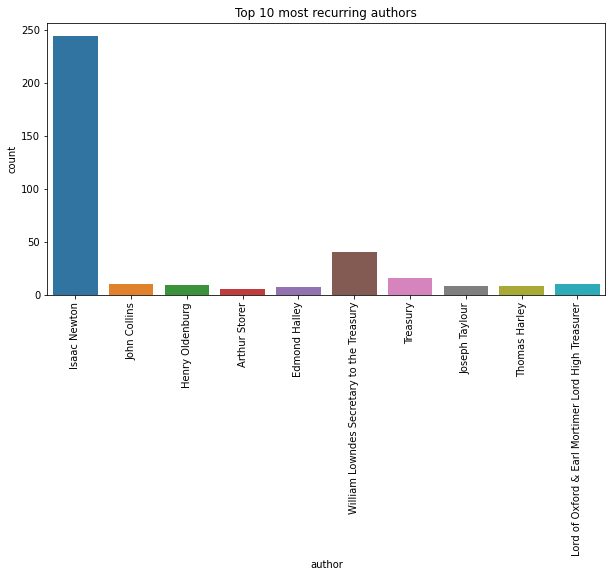

In [26]:
top_10_authors = letters.author.value_counts().index.to_list()[:10]
fig, axes = plt.subplots(figsize = (10, 5))
sns.countplot(data = letters[letters["author"].isin(top_10_authors)], x="author")
plt.xticks(rotation="vertical")
plt.title("Top 10 most recurring authors")
plt.show()

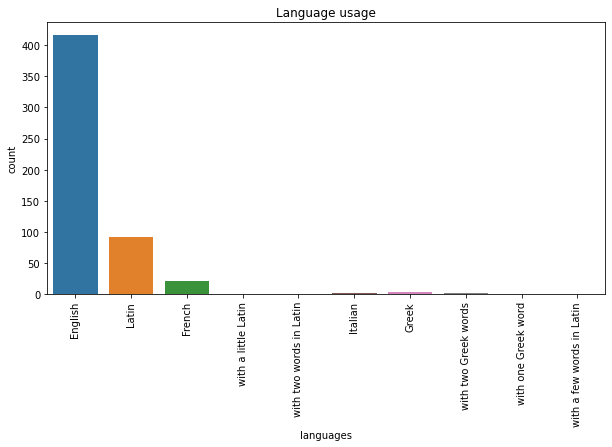

In [27]:
fig, axes = plt.subplots(figsize = (10, 5))
sns.countplot(data = letters.explode("languages"), x = "languages")
plt.xticks(rotation="vertical")
plt.title("Language usage")
plt.show()

<AxesSubplot:title={'center':'Total number of letters per year'}, xlabel='original_date_corrected', ylabel='Count'>

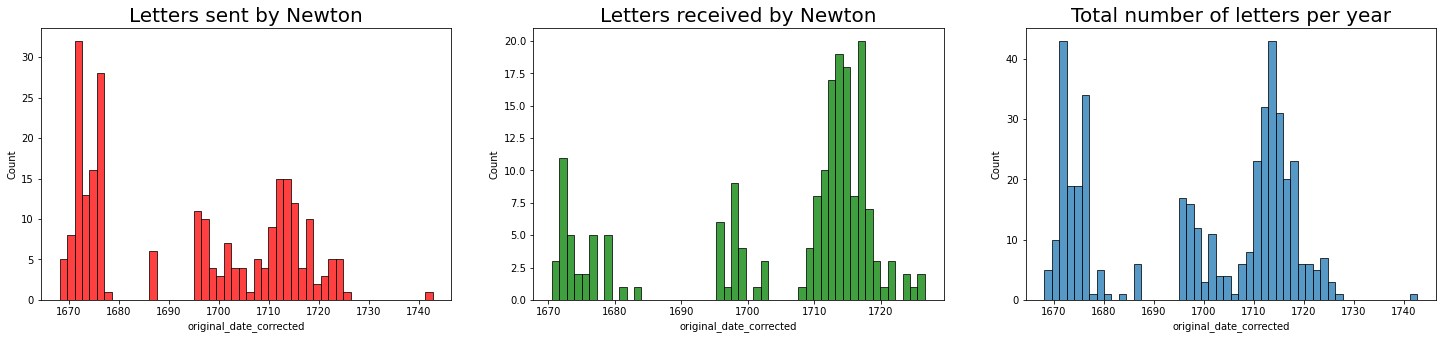

In [28]:
fig, axes = plt.subplots(1,3, figsize = (25, 5))

axes[0].set_title("Letters sent by Newton", fontsize=20)
sns.histplot(data = letters.query("author == 'Isaac Newton'"), x = "original_date_corrected", bins=50, ax=axes[0], color="red")
axes[1].set_title("Letters received by Newton", fontsize=20)
sns.histplot(data = letters.query("author != 'Isaac Newton'"), x = "original_date_corrected", bins=50, ax=axes[1], color="green")
axes[2].set_title("Total number of letters per year", fontsize=20)
sns.histplot(data = letters, x = "original_date_corrected", bins=50, ax=axes[2])

### Content analysis

Making a Spacy object with the first 100 letter

In [ ]:
nlp.max_length = 1_500_000
doc = nlp(" ".join(letters[letters["languages"].apply(lambda row : "English" in row)].letter_content.values[:200]))

Counting the most reccuring words in these letters and printing the top 20 ones

In [ ]:
from collections import Counter

#Without stopwords and punctuation
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words[:20])